# Capstone Project Sandboo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import drawSvg as draw

/Users/ssrosa/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/Users/ssrosa/anaconda3/lib/python3.7/site-packages/drawSvg/raster.py:11: RuntimeWarning: CairoSVG will need to be installed to rasterize images: Install with `pip3 install cairosvg`
  warnings.warn(msg, RuntimeWarning)


In [5]:
class Council(object):
    '''
    Haven't decided yet what zoning attribute should be. For now the zone() method
    does not pull directly from the zoning attribute but rather requires a separate
    zoned_as parameter be passed.
    '''
    def __init__(self, zoning):
        self.zoning = zoning
    def zone(self, land, to_zone_as):
        land.zoned_as.append(to_zone_as)

class District(object):
    def __init__(self):
        self.zoned_as = []
        self.blocks = [[]]
    def update(self):
        #Append last time step's blocks
        self.zoned_as.append(self.zoned_as[-1])
        self.blocks.append([b for b in self.blocks[-1]])        
        
class Block(object):
    def __init__(self, size):
        self.size = size
        self.district = None
        self.zoned_as = []
        #Coords where block is. Just for viz
        self.loc = []
        self.residences = [[]]
    def update(self):
        #Append last time step's residences
        self.zoned_as.append(self.zoned_as[-1])
        self.residences.append([r for r in self.residences[-1]])

class Developer(object):
    def __init__(self):
        self.residences_built = [[]]
        #100sqft - about a 9X12 room
        #Hard coded for now
        self.MIN_RES_SIZE = 425
    def build_on(self, block):
        #Remaining empty land on this block:
        avail_area = block.size - sum([residence.size for residence in block.residences[-1]])
        #If avail_area not large enough to put up a building
        if  avail_area < self.MIN_RES_SIZE:
            return
        #If avail area exceeds min residence size that this developer can build
        else:
            #Distribution of possible sizes for a new residence
            if avail_area > (block.size / 2):
                #Building cannot be bigger than half the block.
                #(Helps with viz.)
                max_res_size = (block.size / 2)
            else:
                #Otherwise building can be as big as the avail land.
                max_res_size = avail_area
            size_dist = np.arange(self.MIN_RES_SIZE, max_res_size + 1)
            #Initialize new residence object
            #Give residence a random size within the realm of possibility
            size = np.random.choice(size_dist)
            residence = Residence(block, size, block.zoned_as[-1])
            #Add residence to last list of residences built on the block
            block.residences[-1].append(residence)
            #Add residence to last list of residence built by this developer
            self.residences_built[-1].append(residence)
    def evict_all(self, residence):
        [u.occ[-1].move_out() for u in residence.units[-1] if u.occ[-1]]
    def demolish(self, residence):
        #Make all households move out
        self.evict_all(residence)
        #Remove this residence from the block's list. (Will remove it from all records moving forward.)
        residence.block.residences[-1].remove(residence)
        #Remove the block from this residence
        residence.block = False

class Residence(object):
    def __init__(self, block, size, zoned_as):
        
        #Building cannot be moved, resized, or rezoned.
        self.block = block
        self.size = size
        self.zoned_as = zoned_as
        #100sqft - about a 9X12 room
        #Hard coded for now
        self.min_unit_size = 100
        
        max_units = self.zoned_as #8 people per unit
        # if zoned_as 8, can have 1 unit
        # if zoned_as 16, can have 2 units
        # if zoned_as 48, cah nave 6 units
        # if zoned as 96, can have 12 units
        self.units = [[]]
        #Not clear at this point whether nested list will be necessary but am including it for now.
        max_units = zoned_as
        #Units can be larger than 100 sqft
        if size / max_units >= self.min_unit_size:
            self.unit_size = size / max_units
        #But cannot be smaller
        else:
            self.unit_size = self.min_unit_size
        avail_area = self.size
        while  avail_area >= self.unit_size:
            #Create a new unit object
            unit = Unit(self, self.unit_size)
            #Add unit object to last item of Residence's units list.
            self.units[-1].append(unit)
            avail_area -= self.unit_size

class Unit(object):
    def __init__(self, residence, size):
        self.residence = residence
        self.size = size
        #Value is a list. -1 is current value.
        self.value = [(size * price_sqft)]
        #Occupant is a list. -1 is current occupant.
        self.occ = [False]
    def update(self):
        self.value.append(self.value[-1])
        self.occ.append(self.occ[-1])

class Household(object):
    '''
    '''
    def __init__(self, has):
        #List of whether the household is homeless or not
        self.housed = [False]
        #Hold income constant for now but still write as a list
        self.has = [has]
    
    def update(self):
        self.housed.append(self.housed[-1])
        self.has.append(self.has[-1])
    
    def can_move_in(self, unit):
        #household needs a place to live
        #unit not already taken
        # household can afford unit 
        if (not self.housed[-1]) \
        and (not unit.occ[-1]) \
        and (unit.value[-1] <= self.has[-1]):        
            return True
        else: 
            return False
    def must_move_out(self):
        #Household has a place to live
        #buts its value has risen above
        #household's spending power
        #Other conditions can be added later
        if (self.housed[-1]) \
        and self.has[-1] < self.housed[-1].value[-1]:
            return True
        else:
            return False
        
    def move_in(self, unit):
        #Household becomes occupant of unit
        unit.occ[-1] = self
        #Houshold marks itself as housed
        self.housed[-1] = unit
        #print(f'Household {self.has[-1]} now lives in unit {unit.value[-1]}')
    
    def move_out(self):
        #Unit loses occupant
        self.housed[-1].occ[-1] = False
        #Household marks itself as unhoused
        self.housed[-1] = False

def create_councils(self, council_count, zoning):
            #Create a council to zone blocks
    councils = []
    for i in range(council_count):
        council = Council(zoning)
        councils.append(council)
    return councils
        
def create_blocks(self, land, block_size_avg, block_size_std):
    new_blocks = []
    #Create a distribution to simulate variety of block sizes
    #block_dist = np.random.normal(scale = block_size_std, loc = block_size_avg, size = block_count)
    #Create a distribution to simulate variety of zoning
    #Empty for now
    size = BLOCK_SIZE
    while land > 0:
        #size = np.round(np.random.choice(block_dist, replace = False), 0)
        #Create a new block only if the block size will fit on the available land left
        if size > land:
            #Need to break the loop here otherwise it keeps running until a random size is
            #drawn that fits the available remaining land. Could be tiny.
            break
        else:
            #Instantiate a block with a random size
            #HARD CODING block SIZE AS  100000
            block = Block(size)
            #Reduce available land area by the size of this block
            land -= size
            #Add this block to the list of blocks in the sim
            new_blocks.append(block)
    #Append this list to the list of blocks as the last item        
    return new_blocks

def create_districts(blocks):
    '''
    Map blocks onto districts evenly.
    '''
    blocks_to_assign = [b for b in blocks]
    districts = []
    for i in range(DISTRICTS_COUNT):
        district = District()
        districts.append(district)
    #While there are still blocks to assign
    while blocks_to_assign:
        #For each district
        for d in districts:
            #If the list hasn't run out of values while iterating
            if blocks_to_assign:
                #Give the first block to the district and remove it from the list of blocks
                blocks_to_assign[0].district = d
                d.blocks[-1].append(blocks_to_assign.pop(0))       
            else:
                break
    return districts
    
def create_developers(self, dev_count):
    '''
    Instantiate some number of developer objects.
    '''
    #For now it's just one developer. Coudl be a list
    developers = []
    for i in range(dev_count):
        developer = Developer()
        developers.append(developer)
    #Return developers as a list to be stored
    return developers

def round_of_zoning(self, council, districts):
    '''
    Takes one council, not a list of councils.

    '''
    #FOR NOW HARD CODING THE ZONES HERE
    zones = [1, 1, 1, 1, 1, 2, 2, 4, 4, 16]
    
    #Zone each district
    for d, z in zip(districts, zones):
        council.zone(d, z)
        #Zone all the blocks the same way as their district
        for b in d.blocks[-1]:
            council.zone(b, d.zoned_as[-1])
                
def round_of_developing(self, developers, blocks):
    '''
    Iterate over list of developers and call each developer's develop method
    '''
    [developer.build_on(block) for block in blocks for developer in developers]

def create_households(self, pop_growth, has_avg, has_std):
    '''
    Create some number of households to come to the city.
    '''
    income_dist = np.random.normal(scale = has_std, loc = has_avg, size = pop_growth)
    new_households = [Household(i) for i in income_dist]
    #self.households[-1].extend(
    #Return the new households as a list
    return new_households

def round_of_moving_in(self):
    '''
    Must be called after time_step() has updated unit and household lists,
    and before round_of_moving_out.
    Prepare lists of units available and unhoused households, then call match()
    to iterate over units to place households in them.
    (What could be a very slow for loop is optimized by preparing shorter lists
    with only the relevant units and households.)
    '''
    print('Round of moving')
    print('#Prepare units and households for moving.')
    #Prepare units and households for moving.
    print('#Step 1: Get units available.')
    #Step 1: Get units available.
    ua = sorted([u for u in self.units[-1] if not u.occ[-1]], \
                        key = lambda u: u.value[-1], reverse = True)
    print(f'{len(ua)} units available')
    print('#Step 2: Get households seeking unit.')
    #Step 2: Get households seeking unit.
    hh = sorted([h for h in self.households[-1] if not h.housed[-1]], \
                        key = lambda h: h.has[-1], reverse = True)
    print(f'{len(hh)} households available')
    print(f'#Step 3: Exclude any units with value above the max spending power of {hh[0].has[-1]}')
    #Step 3: Exclude any units with value above the max spending power 
    #of the households. (Wouldn't be able to rent to anyone)
    ua = [u for u in ua if u.value[-1] <= hh[0].has[-1]]
    #If list is empty, meaning no units are affordable for the richest household
    if not ua:
        print('No units available.')
        return
    print(f'{len(ua)} units available')
    print(f'#Step 4: Exclude any households with spending power less than {ua[0].value[-1]}')
    #Step 4: Exclude any households with spending power less than 
    #the lowest unit value. (Wouldn't be able to find a place.)
    #Keep hh same length as or shorter than ua.
    #(No unit can take more than household so there cannot be more hh than ua.)
    hh = [h for i, h in enumerate(hh) if (h.has[-1] >= ua[-1].value[-1]) and \
                                                                    (i < len(ua))]
    #If list is empty, mmeaning no households can afford what's available
    #This should never happen under the above conditional, but leaving it in for now
    if not hh:
        print('No households looking for units.')
        return
    print(f'{len(hh)} households available')
    print('#Step 5: call the match function to move households into units.')
    #Step 5: call the match function to move households into units.
    hh_remaining = match(hh, ua)
    print(f'{len(hh) - len(hh_remaining)} households out of {len(hh)} found housing')
    #These two numbers should be equal
    #hh_moved_count = sum([1 if h.housed[-1] else 0 for h in hh])
    #ua_moved_into_count = sum([1 if u.occ[-1] else 0 for u in ua])

def match(hh_, ua):
    '''
    Helper function for round of moving. Does the work of matching 
    household to unit. Iterates over units, trying to match each 
    to the highest-value household in the list. If there's a match,
    the household gets popped and the loop moves on to next unit.
    If there's not a match, the loop just moves on to the next unit. 
    A household can take a unit that ncosts less than or equal to
    its spending power. Some rich households may wind up getting 
    cheap units. Units may go untaken; households may go unhoused.

    '''
    #New list to avoid popping the original
    hh = [h for h in hh_]
    #For each unit in list 
    for u in ua:
        #If there are no households left in the list, stop iterating
        if not hh:
            break
        else:
            #If highest-value household can take the unit
            if hh[0].can_move_in(u):
                #Household gets unit
                hh[0].move_in(u)
                #Household gets removed from list
                hh.pop(0)
            #Else: no lower-valued households can take this unit. 
            #It goes unoccupied. Move on to the next unit.
            #Simplest fastest way to iterate over all of them!
    return hh

def round_of_moving_out(self):
    '''
    Must be called after round_of_moving_in().
    A given household should only move_in and move_out once per time step.
    '''
    #Iterate over all households. If a household is housed but 
    #can no longer afford its unit, it moves out.
    test = [h.move_out() for h in self.households[-1] if h.housed[-1] and \
                        h.must_move_out()]
    
    #Should be zero if no hh move out
    print(len(test))                
                
def print_stats(self, time_step):
    print(f'Population at time step {time_step}: {len(self.households[-1])}')
    print(f'{len(self.blocks[-1])} blocks on {LAND} sqft of land')
    print(f'{len(self.developers[-1])} developers')
    #Get number of residences. FOr now there's no master list for some reason
    residences_count = len(self.residences[-1])
    units_count = len(self.units[-1])
    print(f'{residences_count} residences and {units_count} units')
    housing = [True if household.housed[-1] else False for household in self.households[-1]]
    housed_count = sum(housing)
    homeless_count = len(housing) - housed_count
    print(f'{housed_count} households have housing and {homeless_count} households are homeless.')
    
class Simulation(object):
    def __init__(self, 
                 #For creating blocks
                 land, block_count, block_size_avg, block_size_std, zoning,
                 #For bringing builders and rulers to the city
                 dev_count, council_count,
                 #For bringing people to the city
                 pop_growth, has_avg, has_std, 
                 #For running the sim over time
                 total_time_steps, inflation):
        #Number of years to run sim
        self.total_time_steps = total_time_steps
        #List of increments by which to increase population
        self.pop_growth = pop_growth
        #Held as constant for now
        self.has_avg = has_avg
        #Held as constant for now
        self.has_std = has_std
        #Held as constant for now
        self.inflation = inflation
        
        #STEP 0:
        #Create councils
        councils = self.create_councils(council_count, zoning)
        self.councils = [councils]
        
        #STEP 1: 
        #Fill up land area with blocks
        #Will return a list of blocks. Becomes sim.blocks[-1]
        blocks = self.create_blocks(land, block_size_avg, block_size_std)
        self.blocks = [blocks]
    
        #Map all blocks onto districts as evenly as possible. 
        #District count is hard coded as a constant
        #This is done randomly, not by a council, as neighborhoods
        #would coalesce organically in real life.
        districts = create_districts(self.blocks[-1])
        self.districts = [districts]
        #Council zones all the districts and blocks
        #For now its the first council in the list of councils
        self.round_of_zoning(councils[0], self.districts[-1])
       
        #STEP 2: Create developers to build residences
        developers = self.create_developers(dev_count)
        #Start a list of lists of developers to keep track
        self.developers = [developers]
        #Have developers build new residences
        self.round_of_developing(self.developers[-1], self.blocks[-1])
        
        #Start a list of lists of residences
        self.residences = [[r for b in self.blocks[-1] for r in b.residences[-1]]]
        #Start a list of lists of units
        self.units = [[u for r in self.residences[-1] for u in r.units[-1]]]
        
        #STEP 3: Create people to come to the city and move in
        
        #Pop the last value of population growth
        new_households = self.create_households(self.pop_growth.pop(), 
                               self.has_avg, 
                               self.has_std)
        #Start a list of lists of households to keep track
        self.households = [new_households]
        #STEP 4: Let each household try to move into a house
        self.round_of_moving_in()
        
        #STEP 5: Print initial statistics
        print('Simulation started.')
        self.print_stats(0)
        
def time_step(self, step):
    
    #Demolish any old residences
    #pass
    #Kill off any old households
    #pass
    print('\n')
    print(f'Updating object records for time step {step}')
    #Update lists of objects:
    print(f'1. Copy list of blocks from time step {step - 1}')
    self.blocks.append([b for b in self.blocks[-1]])
    print('2. Update each block\'s own records')
    [b.update() for b in self.blocks[-1]]
    print('3. Update each unit\'s own records')
    #Update each existing unit
    [u.update() for u in self.units[-1]]
    #Update each existing household
    print(f'4. Copy list of developers from time step {step - 1}')
    self.developers.append([d for d in self.developers[-1]])
   
    print(f'5. Copy list of households from time step {step - 1}: ({len(self.households[-1])})')
    #Copy list of households from previous time step
    self.households.append([h for h in self.households[-1]])
    print(f'6. Update each household\'s own records')
    [h.update() for h in self.households[-1]]
    
    #Inflation increases values or something
    
    #New developers
    #Leave out for now
    #Will need to extend [-1] spot of developer list with any new developers
    
    #New households move to town
    print(f'7.New households coming to town!')
    new_households = self.create_households(self.pop_growth.pop(), self.has_avg, self.has_std)
    print(f'{len(new_households)} households arrived')
    self.households[-1].extend(new_households)
    #test to make sure lists of households are updating correctly
    #print([len(h_list) for h_list in self.households])
    print('8. Developers are building new residences on vacant land')
    #Build new residences on available land
    self.round_of_developing(self.developers[-1], self.blocks[-1])
    #Manually append the list of all residences
    print('9. Updating master of list of residences to include new construction')
    self.residences.append([r for b in self.blocks[-1] for r in b.residences[-1]])
    #Need to manually add units to list for sim
    print('appending new units to master list')
    self.units.append([u for r in self.residences[-1] for u in r.units[-1]])
    #Have homeless try to move into new places
    print('people moving in')
    self.round_of_moving_in()
    
    #Have those priced out of their units move out
    #Shoudl always be a different group of people who move in/out within a year
    print('people moving out')
    self.round_of_moving_out()
    
def run(self):
    pass
    for _ in tqdm(range(self.total_time_steps)):
        # Print out the current time step 
        print(f"Time step {_}")
        self.time_step(_)
        self.print_stats(_)

In [3]:
#Attach all these functions to the Simulation object
Simulation.create_councils = create_councils
Simulation.create_blocks = create_blocks
Simulation.create_developers = create_developers
Simulation.create_households = create_households
Simulation.round_of_zoning = round_of_zoning
Simulation.round_of_developing = round_of_developing        
Simulation.round_of_moving_in = round_of_moving_in
Simulation.round_of_moving_out = round_of_moving_out
Simulation.print_stats = print_stats
Simulation.time_step = time_step
Simulation.run = run

#CITY SETTINGS
#Size of land area in sqft (for now)
LAND = 1000020000 #one trillion sqft in SF #1000000000
block_count = 10
DISTRICTS_COUNT = 10
BLOCK_SIZE = 102000
#Avg and std not used for now
block_size_avg = 10000 #50000
block_size_std = 150
zoning = [1]

#Starting developers
DEV_COUNT = 10
#Starting councils
COUNCIL_COUNT = 1

#Starting population
pop_growth = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 100000]

has_avg = 1500
has_std = 500

#Time and money
price_sqft = 10
inflation = 0.02
years = 10

In [4]:
%%time
#CREATE SIM
sim = Simulation(land = LAND, 
                 block_count = block_count, 
                 block_size_avg = block_size_avg, 
                 block_size_std = block_size_std,
                 zoning = zoning,
                 dev_count = DEV_COUNT,
                 council_count = COUNCIL_COUNT,
                 pop_growth = pop_growth, 
                 has_avg = has_avg, 
                 has_std = has_std, 
                 total_time_steps = years,
                 inflation = inflation
                 )


max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 39851.0
max res size is avail area, 34187.0
max res size is avail area, 2909.0
max res size is avail area, 2112.0
max res size is avail area, 984.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 11513.0
max res size is avail area, 10936.0
max res size is avail area, 4200.0
max res size is avail area, 3137.0
max res size is avail area, 1419.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 29611.0
max res size is avail area, 21819.0
max res size is avail area, 9267.0
max res size is avail area, 3739.0
max res size is avail area, 745.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 495

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 31238.0
max res size is avail area, 20001.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45597.0
max res size is avail area, 17078.0
max res size is avail area, 8245.0
max res size is avail area, 2891.0
max res size is avail area, 1260.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 35700.0
max res size is avail area, 31581.0
max res size is avail area, 25550.0
max res size is avail area, 12427.0
max res size is avail area, 1430.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42308.0
max res size is avail area, 21727.0
max res size is 

max res size is avail area, 19812.0
max res size is avail area, 10958.0
max res size is avail area, 6807.0
max res size is avail area, 5703.0
max res size is avail area, 3055.0
max res size is avail area, 455.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 50435.0
max res size is avail area, 18559.0
max res size is avail area, 9046.0
max res size is avail area, 1298.0
max res size is avail area, 802.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47709.0
max res size is avail area, 13077.0
max res size is avail area, 2135.0
max res size is avail area, 1285.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 221

max res size is avail area, 2119.0
max res size is avail area, 850.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 37220.0
max res size is avail area, 22039.0
max res size is avail area, 12330.0
max res size is avail area, 6313.0
max res size is avail area, 3778.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 33447.0
max res size is avail area, 20734.0
max res size is avail area, 1878.0
max res size is avail area, 448.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 14793.0
max res size is avail area, 11608.0
max res size is avail area, 6946.0
max res size is avail area, 4086.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 15254.0
max res size is avail area, 1150.0
max

max res size is avail area, 20439.0
max res size is avail area, 5665.0
max res size is avail area, 2414.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 11544.0
max res size is avail area, 2625.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 23126.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 14473.0
max res size is avail area, 11025.0
max res size is avail area, 5989.0
max res size is avail area, 1138.0
max res size is avail area, 606.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 16332.0
max

max res size is avail area, 19979.0
max res size is avail area, 3317.0
max res size is avail area, 2730.0
max res size is avail area, 581.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 25429.0
max res size is avail area, 17272.0
max res size is avail area, 15948.0
max res size is avail area, 14136.0
max res size is avail area, 865.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 43292.0
max res size is avail area, 23589.0
max res size is avail area, 20604.0
max res size is avail area, 9995.0
max res size is avail area, 5590.0
max res size is avail area, 1954.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 4

max res size is avail area, 46082.0
max res size is avail area, 4928.0
max res size is avail area, 486.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 38309.0
max res size is avail area, 23475.0
max res size is avail area, 15806.0
max res size is avail area, 3415.0
max res size is avail area, 2316.0
max res size is avail area, 499.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 39810.0
max res size is avail area, 6972.0
max res size is avail area, 3488.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 37859.0
max res size is avail area, 11101.0
max res size is avail area, 5349.0
max res size is avail area, 46

max res size is half of block size, 51000.0
max res size is avail area, 37460.0
max res size is avail area, 3266.0
max res size is avail area, 728.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45528.0
max res size is avail area, 5827.0
max res size is avail area, 3734.0
max res size is avail area, 1069.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42444.0
max res size is avail area, 5842.0
max res size is avail area, 4857.0
max res size is avail area, 2150.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 32621.0
max res size is avail area, 3443.0
max res size is avail area, 806.0
max res size is half of 

max res size is half of block size, 51000.0
max res size is avail area, 36459.0
max res size is avail area, 13954.0
max res size is avail area, 863.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 12013.0
max res size is avail area, 2217.0
max res size is avail area, 1689.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 50390.0
max res size is avail area, 39666.0
max res size is avail area, 25548.0
max res size is avail area, 7467.0
max res size is avail area, 6336.0
max res size is avail area, 3514.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 38874.0
max res size is avail area, 31084.0
max res size is ava

max res size is half of block size, 51000.0
max res size is avail area, 34740.0
max res size is avail area, 15937.0
max res size is avail area, 14885.0
max res size is avail area, 2456.0
max res size is avail area, 1608.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 41561.0
max res size is avail area, 23410.0
max res size is avail area, 1494.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 33420.0
max res size is avail area, 10706.0
max res size is avail area, 5490.0
max res size is avail area, 3794.0
max res size is avail area, 2907.0
max res size is avail area, 2177.0
max res size is avail area, 1471.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 41996.0
max res size is avail area, 31205.0


max res size is avail area, 4840.0
max res size is avail area, 2256.0
max res size is avail area, 1401.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42193.0
max res size is avail area, 37951.0
max res size is avail area, 30522.0
max res size is avail area, 16459.0
max res size is avail area, 3283.0
max res size is avail area, 584.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 12173.0
max res size is avail area, 9775.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 41673.0
max res size is avail area, 30576.0
max res size is avail area, 19280.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 49722.0
max res size is avail area,

max res size is avail area, 43967.0
max res size is avail area, 19283.0
max res size is avail area, 12967.0
max res size is avail area, 6903.0
max res size is avail area, 5646.0
max res size is avail area, 2371.0
max res size is avail area, 1610.0
max res size is avail area, 1046.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 33041.0
max res size is avail area, 30183.0
max res size is avail area, 26056.0
max res size is avail area, 18202.0
max res size is avail area, 15717.0
max res size is avail area, 710.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45955.0
max res size is avail area, 11641.0
max res size is avail area, 7212.0
max res size is avail area, 1723.0
max res size is avail area, 524.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is hal

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 28990.0
max res size is avail area, 1778.0
max res size is avail area, 1305.0
max res size is avail area, 481.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 30815.0
max res size is avail area, 7770.0
max res size is avail area, 2267.0
max res size is avail area, 1716.0
max res size is avail area, 447.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 36073.0
max res size is avail area, 16041.0
max res size is avail area, 7142.0
max res size is avail area, 4589.0
max res size is avail area, 1942.0
max res size is avail area, 868.0
max res size is half of block size, 51000.0
max res size is half of block size

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 38449.0
max res size is avail area, 30992.0
max res size is avail area, 26025.0
max res size is avail area, 4353.0
max res size is avail area, 3062.0
max res size is avail area, 488.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47634.0
max res size is avail area, 23011.0
max res size is avail area, 14708.0
max res size is avail area, 5247.0
max res size is avail area, 1404.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 48112.0
max res size is avail area, 46479.0
max res size is avail area, 18691.0
max res size is avail area, 15279.0
max res size is avail area, 2901.0
max res size is avail area, 1998.0
max res size is avail area, 1562.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res s

max res size is avail area, 9285.0
max res size is avail area, 4882.0
max res size is avail area, 3595.0
max res size is avail area, 3004.0
max res size is avail area, 2045.0
max res size is avail area, 1120.0
max res size is avail area, 476.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 49082.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 25068.0
max res size is avail area, 3551.0
max res size is avail area, 570.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 40665.0
max res size is avail area, 16052.0
max res size is avail area, 10728.0
max res size is avail area, 5175.0
max res size is avail area, 2510.0
max res size is avail area, 1866.0
max res size is avail area, 635.0
max res size is half of block size, 51000.0
max res size is 

max res size is avail area, 4340.0
max res size is avail area, 3414.0
max res size is avail area, 2295.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 38216.0
max res size is avail area, 29825.0
max res size is avail area, 13983.0
max res size is avail area, 8092.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 28782.0
max res size is avail area, 13782.0
max res size is avail area, 7979.0
max res size is avail area, 2609.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 27831.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 27395.0
max res size is avail area, 3527.0
max res size is ava

max res size is avail area, 50589.0
max res size is avail area, 4004.0
max res size is avail area, 1787.0
max res size is avail area, 1098.0
max res size is avail area, 539.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 33926.0
max res size is avail area, 7121.0
max res size is avail area, 880.0
max res size is avail area, 451.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 31027.0
max res size is avail area, 9227.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 46886.0
max res size is avail area, 31377.0
max res size is avail area, 5660.0
max res size is avail ar

max res size is avail area, 2852.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 31701.0
max res size is avail area, 29612.0
max res size is avail area, 11966.0
max res size is avail area, 7844.0
max res size is avail area, 515.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45454.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 20847.0
max res size is avail area, 15725.0
max res size is avail area, 11339.0
max res size is avail area, 5740.0
max res size is avail area, 3961.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 43115.0
max res size is avail area, 13713.0
max res size is avail area, 3645.0
max res size is avail area, 1073.0
max res size is half of block size, 51000.0
max res size is half of block size, 

max res size is avail area, 40201.0
max res size is avail area, 37295.0
max res size is avail area, 29762.0
max res size is avail area, 19162.0
max res size is avail area, 16924.0
max res size is avail area, 12510.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 46823.0
max res size is avail area, 20332.0
max res size is avail area, 12210.0
max res size is avail area, 774.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 37179.0
max res size is avail area, 13916.0
max res size is avail area, 10613.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45410.0
max res size is avail area, 5863.0
max res size is avail area, 2791.0
max res size is avail area, 2007

max res size is avail area, 39572.0
max res size is avail area, 7360.0
max res size is avail area, 1000.0
max res size is avail area, 536.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 30169.0
max res size is avail area, 15551.0
max res size is avail area, 12424.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 40743.0
max res size is avail area, 32487.0
max res size is avail area, 11935.0
max res size is avail area, 6197.0
max res size is avail area, 2106.0
max res size is avail area, 1561.0
max res size is avail area, 1103.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 36274.0
max res size is avail area, 3748.0
max res size is avail area, 1908.0
ma

max res size is half of block size, 51000.0
max res size is avail area, 44185.0
max res size is avail area, 31411.0
max res size is avail area, 1517.0
max res size is avail area, 785.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47979.0
max res size is avail area, 26713.0
max res size is avail area, 19966.0
max res size is avail area, 4894.0
max res size is avail area, 4268.0
max res size is avail area, 752.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 44373.0
max res size is avail area, 24791.0
max res size is avail area, 12845.0
max res size is avail area, 8830.0
max res size is avail area, 6098.0
max res size is avail area, 3728.0
max res size is avail area, 2494.0
max res size is avail area, 1775.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size

max res size is avail area, 23435.0
max res size is avail area, 19993.0
max res size is avail area, 17989.0
max res size is avail area, 4582.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 13429.0
max res size is avail area, 5744.0
max res size is avail area, 4261.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 13012.0
max res size is avail area, 8925.0
max res size is avail area, 5333.0
max res size is avail area, 2495.0
max res size is avail area, 595.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 7404.0
max res size is avail area, 4531.0
max res size is avail area, 2997.0
max res size is avail area, 1957.0
max res size is avail area, 548.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max re

max res size is avail area, 12120.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 41204.0
max res size is avail area, 14402.0
max res size is avail area, 8755.0
max res size is avail area, 1412.0
max res size is avail area, 696.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 14347.0
max res size is avail area, 8812.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 46924.0
max res size is avail area, 6225.0
max res size is avail area, 3270.0
max res size is avail area, 1943.0
max res size is avail area, 426.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 49742.0
max res size is avail area, 23411.0
max res size is avail area, 83

max res size is avail area, 1529.0
max res size is avail area, 1062.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 23708.0
max res size is avail area, 8009.0
max res size is avail area, 3173.0
max res size is avail area, 638.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 50936.0
max res size is avail area, 29110.0
max res size is avail area, 4264.0
max res size is avail area, 737.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 15434.0
max res size is avail area, 5498.0
max res size is avail area, 4787.0
max res size is avail area, 3305.0
max res size is avail area, 1192.0
max res size is half of block size, 51000.0
max res size is half of block siz

max res size is avail area, 46387.0
max res size is avail area, 10788.0
max res size is avail area, 8319.0
max res size is avail area, 7135.0
max res size is avail area, 4437.0
max res size is avail area, 740.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45139.0
max res size is avail area, 12989.0
max res size is avail area, 5642.0
max res size is avail area, 750.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 11043.0
max res size is avail area, 10133.0
max res size is avail area, 1792.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45937.0
max res size is avail area, 37712.0
max res size is avail area, 11148.0
max res size is avail area, 4395.0
ma

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 36096.0
max res size is avail area, 29402.0
max res size is avail area, 9292.0
max res size is avail area, 6968.0
max res size is avail area, 2400.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 46865.0
max res size is avail area, 29881.0
max res size is avail area, 8175.0
max res size is avail area, 954.0
max res size is avail area, 467.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 17495.0
max res size is avail area, 2081.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 23049.0
max res size is avail area, 4638.0
max res size is avail 

max res size is avail area, 13761.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 24297.0
max res size is avail area, 430.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 44235.0
max res size is avail area, 25143.0
max res size is avail area, 7423.0
max res size is avail area, 6280.0
max res size is avail area, 3066.0
max res size is avail area, 1202.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 4731.0
max res size is avail area, 3620.0
max res size is avail area, 2001.0
max res size is avail area, 1462.0
max res size is half of block size, 51000.0
max res size i

max res size is avail area, 39501.0
max res size is avail area, 567.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45996.0
max res size is avail area, 2988.0
max res size is avail area, 831.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 31712.0
max res size is avail area, 12029.0
max res size is avail area, 6884.0
max res size is avail area, 4749.0
max res size is avail area, 1514.0
max res size is avail area, 552.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 26000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 23584.0
max res size is avail area, 9938.0
max res size is avail area, 870.0
max res size is half of block siz

max res size is avail area, 11053.0
max res size is avail area, 9792.0
max res size is avail area, 1244.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 49143.0
max res size is avail area, 34022.0
max res size is avail area, 1086.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47755.0
max res size is avail area, 8168.0
max res size is avail area, 7456.0
max res size is avail area, 5896.0
max res size is avail area, 4733.0
max res size is avail area, 2321.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 48362.0
max res size is avail area, 43448.0
max res size is avail area, 13123.0
max res size is avail area, 12001.0
max res size is avail area, 4290.0
max res size is avail area, 2416.0
max res size is avail area, 1784.0
max res size is half of block size, 51000.0
max res size is hal

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 37603.0
max res size is avail area, 31451.0
max res size is avail area, 14091.0
max res size is avail area, 4085.0
max res size is avail area, 2456.0
max res size is avail area, 1653.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 12027.0
max res size is avail area, 8080.0
max res size is avail area, 3421.0
max res size is avail area, 456.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 15211.0
max res size is avail area, 4116.0
max res size is avail area, 1545.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size 

max res size is half of block size, 51000.0
max res size is avail area, 41766.0
max res size is avail area, 5206.0
max res size is avail area, 2013.0
max res size is avail area, 1534.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 20679.0
max res size is avail area, 19560.0
max res size is avail area, 2170.0
max res size is avail area, 1108.0
max res size is avail area, 467.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 19900.0
max res size is avail area, 12461.0
max res size is avail area, 5184.0
max res size is avail area, 1014.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size 

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 13957.0
max res size is avail area, 6626.0
max res size is avail area, 2694.0
max res size is avail area, 1220.0
max res size is avail area, 648.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 35851.0
max res size is avail area, 23646.0
max res size is avail area, 17724.0
max res size is avail area, 2201.0
max res size is avail area, 736.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42098.0
max res size is avail area, 36577.0
max res size is avail area, 24554.0
max res size is avail area, 9861.0
max res size is avail area, 5592.0
max res size is avail area, 4761.0
max res size is avail area, 3121.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max 

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 9291.0
max res size is avail area, 4555.0
max res size is avail area, 4126.0
max res size is avail area, 3563.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 40923.0
max res size is avail area, 9967.0
max res size is avail area, 9422.0
max res size is avail area, 6395.0
max res size is avail area, 4311.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 39718.0
max res size is avail area, 8922.0
max res size is avail area, 444.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 44679.0
max res size is avail area, 36042.0
max res size is avail area, 25299.0
max res size is avail area, 227

max res size is avail area, 31249.0
max res size is avail area, 28964.0
max res size is avail area, 19744.0
max res size is avail area, 7947.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42383.0
max res size is avail area, 12458.0
max res size is avail area, 2463.0
max res size is avail area, 667.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 30873.0
max res size is avail area, 25201.0
max res size is avail area, 743.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 12535.0
max res size is avail area, 5800.0
max res size is avail area, 654.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 4709.0
max res size is avail area, 1776.0
max res size is avail area, 992.0
max res size is half of block size, 51000.0
max r

max res size is avail area, 43556.0
max res size is avail area, 39179.0
max res size is avail area, 38336.0
max res size is avail area, 9655.0
max res size is avail area, 6118.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47646.0
max res size is avail area, 16486.0
max res size is avail area, 874.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 32701.0
max res size is avail area, 1771.0
max res size is avail area, 1305.0
max res size is avail area, 637.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 38696.0
max res size is avail area, 4995.0
max res size is avail area, 4435.0
max res size is avail area, 890.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 29881.0
max 

max res size is half of block size, 51000.0
max res size is avail area, 45299.0
max res size is avail area, 25191.0
max res size is avail area, 8874.0
max res size is avail area, 3990.0
max res size is avail area, 3363.0
max res size is avail area, 685.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 8975.0
max res size is avail area, 2560.0
max res size is avail area, 1176.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 37332.0
max res size is avail area, 27725.0
max res size is avail area, 22936.0
max res size is avail area, 2192.0
max res size is avail area, 1216.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42651.0
max res size is avail area, 34767.0
max res size is avail area, 470.0
max res size is half of block size, 51000.0
max 

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 9227.0
max res size is avail area, 2742.0
max res size is avail area, 1416.0
max res size is avail area, 860.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 24164.0
max res size is avail area, 15572.0
max res size is avail area, 11503.0
max res size is avail area, 3877.0
max res size is avail area, 1037.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 46802.0
max res size is avail area, 45582.0
max res size is avail area, 4363.0
max res size is avail area, 2901.0
max res size is avail area, 690.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of

max res size is avail area, 32471.0
max res size is avail area, 29457.0
max res size is avail area, 25910.0
max res size is avail area, 3846.0
max res size is avail area, 1071.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 18385.0
max res size is avail area, 6608.0
max res size is avail area, 4086.0
max res size is avail area, 2766.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42280.0
max res size is avail area, 32663.0
max res size is avail area, 2585.0
max res size is avail area, 2001.0
max res size is avail area, 1399.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 13120.0
max res size is avail area, 10148.0
max res size is avail area, 2315.0
m

max res size is avail area, 7296.0
max res size is avail area, 5747.0
max res size is avail area, 2488.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 22486.0
max res size is avail area, 19100.0
max res size is avail area, 15735.0
max res size is avail area, 4369.0
max res size is avail area, 2685.0
max res size is avail area, 1272.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 12442.0
max res size is avail area, 5659.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 33397.0
max res size is avail area, 3630.0
max res size is avail area, 2818.0
max res size is avail area, 1430.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 40336.0
max res size is avail area, 29494.0
max res size is avail area, 28909.0
max res size is avail area, 25676.0
max res size is avail area, 3660.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 9920.0
max res size is avail area, 7854.0
max res size is avail area, 3374.0
max res size is avail area, 939.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45799.0
max res size is avail area, 43720.0
max res size is avail area, 42065.0
max res size is avail area, 27996.0
max res size is avail area, 15088.0
max res size is avail area, 14604.0
max res size is avail area, 8617.0
max res size is avail area, 2723.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0


max res size is avail area, 3342.0
max res size is avail area, 561.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 20365.0
max res size is avail area, 3843.0
max res size is avail area, 1660.0
max res size is avail area, 1127.0
max res size is avail area, 653.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 34547.0
max res size is avail area, 17271.0
max res size is avail area, 5709.0
max res size is avail area, 3316.0
max res size is avail area, 1752.0
max res size is avail area, 1269.0
max res size is avail area, 459.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 44266.0
max res size is avail area, 21823.0
max res size is avail area, 15284.0
max res size is avail area, 14702.0
max res size is avail area, 9681.0
max res size is avail a

max res size is avail area, 26128.0
max res size is avail area, 15726.0
max res size is avail area, 9075.0
max res size is avail area, 1405.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 43860.0
max res size is avail area, 24487.0
max res size is avail area, 2597.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 35982.0
max res size is avail area, 10496.0
max res size is avail area, 7298.0
max res size is avail area, 3116.0
max res size is avail area, 1164.0
max res size is avail area, 565.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 37786.0
max res size is avail area, 30332.0
max res size is avail area, 6376.0
max res size is avail area, 2642.0
ma

max res size is half of block size, 51000.0
max res size is avail area, 23314.0
max res size is avail area, 22375.0
max res size is avail area, 13666.0
max res size is avail area, 4042.0
max res size is avail area, 2902.0
max res size is avail area, 2155.0
max res size is avail area, 1277.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 48671.0
max res size is avail area, 21640.0
max res size is avail area, 12391.0
max res size is avail area, 1403.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42229.0
max res size is avail area, 38547.0
max res size is avail area, 7064.0
max res size is avail area, 2462.0
max res size is avail area, 1696.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47580.0
max res size is avail area, 46309.0
max res size is avail area, 13450.0
max res size is 

max res size is half of block size, 51000.0
max res size is avail area, 12556.0
max res size is avail area, 11067.0
max res size is avail area, 1366.0
max res size is avail area, 840.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 35663.0
max res size is avail area, 10947.0
max res size is avail area, 5890.0
max res size is avail area, 3124.0
max res size is avail area, 2055.0
max res size is avail area, 1471.0
max res size is avail area, 457.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 48331.0
max res size is avail area, 24160.0
max res size is avail area, 23448.0
max res size is avail area, 4070.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 26387.0
max res size is avail area, 14585.0
ma

max res size is half of block size, 51000.0
max res size is avail area, 48498.0
max res size is avail area, 35582.0
max res size is avail area, 25164.0
max res size is avail area, 1889.0
max res size is avail area, 1206.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 19291.0
max res size is avail area, 17825.0
max res size is avail area, 7741.0
max res size is avail area, 5619.0
max res size is avail area, 788.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 39138.0
max res size is avail area, 16260.0
max res size is avail area, 3232.0
max res size is avail area, 2076.0
max res size is avail area, 1603.0
max res size is avail area, 847.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 44920.0
max

max res size is half of block size, 51000.0
max res size is avail area, 46997.0
max res size is avail area, 7132.0
max res size is avail area, 2517.0
max res size is avail area, 895.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 17239.0
max res size is avail area, 6226.0
max res size is avail area, 3687.0
max res size is avail area, 1765.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 32711.0
max res size is avail area, 26923.0
max res size is avail area, 11575.0
max res size is avail area, 9897.0
max res size is avail area, 8902.0
max res size is avail area, 7688.0
max res size is avail area, 907.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 49747.0
max res size is avail area, 9992.0
max res size is avail area, 7899.0
max res size is avail area, 3021.0
max res size is avail a

max res size is half of block size, 51000.0
max res size is avail area, 50724.0
max res size is avail area, 14982.0
max res size is avail area, 2804.0
max res size is avail area, 1787.0
max res size is avail area, 804.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 40435.0
max res size is avail area, 33917.0
max res size is avail area, 7655.0
max res size is avail area, 1851.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 24224.0
max res size is avail area, 796.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47530.0
max res size is avail area, 5371.0
max res size is avail area, 982.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 46604.0
max res size is avail area, 26734.0
max res size is avail area, 7846.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 35646.0
max res size is avail area, 27266.0
max res size is avail area, 18050.0
max res size is avail area, 2946.0
max res size is avail area, 1336.0
max res size is avail area, 718.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 8596.0
max res size is avail area, 7239.0
max res size is avail area, 4328.0
max res size is avail area, 1432.0
max res size is avail area, 649.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 39248.0
max res size is avail area, 229

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 17775.0
max res size is avail area, 8471.0
max res size is avail area, 2128.0
max res size is avail area, 1464.0
max res size is avail area, 431.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 38343.0
max res size is avail area, 33017.0
max res size is avail area, 5282.0
max res size is avail area, 1864.0
max res size is avail area, 635.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47840.0
max res size is avail area, 26427.0
max res size is avail area, 4151.0
max res size is avail area, 3388.0
max res size is avail area, 2713.0
max res size is avail area, 1726.0
max res size is avail area, 488.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res

max res size is avail area, 9509.0
max res size is avail area, 6250.0
max res size is avail area, 2191.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 40632.0
max res size is avail area, 899.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 46695.0
max res size is avail area, 38922.0
max res size is avail area, 28973.0
max res size is avail area, 10524.0
max res size is avail area, 5372.0
max res size is avail area, 2069.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 18839.0
max res size is avail area, 11731.0
max res size is avail area, 1125.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 29612.0
max res size is avail area, 

max res size is half of block size, 51000.0
max res size is avail area, 11890.0
max res size is avail area, 10276.0
max res size is avail area, 4743.0
max res size is avail area, 2633.0
max res size is avail area, 1217.0
max res size is avail area, 679.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 35395.0
max res size is avail area, 9247.0
max res size is avail area, 7347.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45845.0
max res size is avail area, 2706.0
max res size is avail area, 1756.0
max res size is avail area, 540.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 7925.0
max res size is avail area, 6951.0
max res size is half of block siz

max res size is avail area, 4386.0
max res size is avail area, 2784.0
max res size is avail area, 1163.0
max res size is avail area, 476.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 33160.0
max res size is avail area, 2423.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 50118.0
max res size is avail area, 2434.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 17171.0
max res size is avail area, 7567.0
max res size is avail area, 4278.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000

max res size is avail area, 11801.0
max res size is avail area, 6453.0
max res size is avail area, 3196.0
max res size is avail area, 1926.0
max res size is avail area, 1090.0
max res size is avail area, 599.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 25750.0
max res size is avail area, 8531.0
max res size is avail area, 4316.0
max res size is avail area, 3360.0
max res size is avail area, 610.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 40440.0
max res size is avail area, 35053.0
max res size is avail area, 17551.0
max res size is avail area, 3276.0
max res size is avail area, 480.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 43373.0
max re

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 46682.0
max res size is avail area, 9290.0
max res size is avail area, 3166.0
max res size is avail area, 1152.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 31704.0
max res size is avail area, 1672.0
max res size is avail area, 896.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 36804.0
max res size is avail area, 35363.0
max res size is avail area, 21969.0
max res size is avail area, 10131.0
max res size is avail area, 9187.0
max res size is avail area, 5011.0
max res size is avail area, 1658.0
max res size is avail area, 1215.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 41094.0
max res size is avail area, 31087.0
max res size is avail area, 27609.0
max res si

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 20045.0
max res size is avail area, 6382.0
max res size is avail area, 4701.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 9903.0
max res size is avail area, 4983.0
max res size is avail area, 3979.0
max res size is avail area, 2870.0
max res size is avail area, 1909.0
max res size is avail area, 440.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 32114.0
max res size is avail area, 29677.0
max res size is avail area, 9226.0
max res size is avail area, 5795.0
max res size is avail area, 530.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 24219.0
max res size is avail area, 15404.0
max res size is avail area, 1538.0
max res size is half of block size, 51000.0
max re

max res size is half of block size, 51000.0
max res size is avail area, 41206.0
max res size is avail area, 32676.0
max res size is avail area, 10170.0
max res size is avail area, 5229.0
max res size is avail area, 1314.0
max res size is avail area, 851.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 39841.0
max res size is avail area, 7261.0
max res size is avail area, 4975.0
max res size is avail area, 2397.0
max res size is avail area, 657.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45293.0
max res size is avail area, 7666.0
max res size is avail area, 1447.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 26619.0
max res size is avail area, 24952.0
max res size is avail area, 885.0
max r

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 20638.0
max res size is avail area, 12375.0
max res size is avail area, 11546.0
max res size is avail area, 9029.0
max res size is avail area, 6433.0
max res size is avail area, 2990.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 37539.0
max res size is avail area, 33893.0
max res size is avail area, 6452.0
max res size is avail area, 939.0
max res size is avail area, 460.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 48890.0
max res size is avail area, 8766.0
max res size is avail area, 8219.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half o

max res size is avail area, 11320.0
max res size is avail area, 1947.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 43083.0
max res size is avail area, 42565.0
max res size is avail area, 36171.0
max res size is avail area, 5275.0
max res size is avail area, 4844.0
max res size is avail area, 3431.0
max res size is avail area, 2798.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 49716.0
max res size is avail area, 13859.0
max res size is avail area, 2315.0
max res size is avail area, 1521.0
max res size is avail area, 1092.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 36782.0
max res size is avail area, 26298.0
max res size is half of block size, 51000.0
max res size is half of block size, 

max res size is avail area, 3638.0
max res size is avail area, 1813.0
max res size is avail area, 1190.0
max res size is avail area, 703.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 19594.0
max res size is avail area, 3216.0
max res size is avail area, 1891.0
max res size is avail area, 1326.0
max res size is avail area, 446.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 33693.0
max res size is avail area, 33126.0
max res size is avail area, 3842.0
max res size is avail area, 1971.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 42452.0
max res size is avail area, 41200.0
max res size is avail area, 16137.0
max res size is avail area, 12842.0
max res size is avail area, 7788.0
max res size is avail area, 484.0
max res size is half of block size, 51000.0
max res size is half of

max res size is avail area, 10183.0
max res size is avail area, 4784.0
max res size is avail area, 4290.0
max res size is avail area, 3563.0
max res size is avail area, 672.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 12969.0
max res size is avail area, 10138.0
max res size is avail area, 1265.0
max res size is avail area, 572.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 16373.0
max res size is avail area, 4118.0
max res size is avail area, 3257.0
max res size is avail area, 675.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 6591.0
max res size is avail area, 3726.0
max res size is avail area, 707.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0


max res size is avail area, 36811.0
max res size is avail area, 30059.0
max res size is avail area, 22603.0
max res size is avail area, 18224.0
max res size is avail area, 13345.0
max res size is avail area, 4239.0
max res size is avail area, 2485.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 45679.0
max res size is avail area, 41512.0
max res size is avail area, 26473.0
max res size is avail area, 18119.0
max res size is avail area, 17327.0
max res size is avail area, 6357.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 15440.0
max res size is avail area, 14374.0
max res size is avail area, 4096.0
max res size is avail area, 2277.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 35571.0
max r

max res size is avail area, 434.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 28444.0
max res size is avail area, 21535.0
max res size is avail area, 20608.0
max res size is avail area, 6489.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 29508.0
max res size is avail area, 1416.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 38781.0
max res size is avail area, 20623.0
max res size is avail area, 3777.0
max res size is avail area, 2562.0
max res size is avail area, 845.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 10337.0
max res size is avail area, 6565.0
max res size is avail

max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 26209.0
max res size is avail area, 23854.0
max res size is avail area, 22798.0
max res size is avail area, 15034.0
max res size is avail area, 4614.0
max res size is avail area, 2440.0
max res size is avail area, 1851.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 29288.0
max res size is avail area, 23904.0
max res size is avail area, 20495.0
max res size is avail area, 19728.0
max res size is avail area, 6073.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 47907.0
max res size is avail area, 34056.0
max res size is avail area, 23241.0
max res size is avail area, 11666.0
max res size is avail area, 8511.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 8675.0
max re

max res size is half of block size, 51000.0
max res size is avail area, 45250.0
max res size is avail area, 36594.0
max res size is avail area, 21579.0
max res size is avail area, 13827.0
max res size is avail area, 9256.0
max res size is avail area, 3006.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 43136.0
max res size is avail area, 35748.0
max res size is avail area, 20712.0
max res size is avail area, 6922.0
max res size is avail area, 5061.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is half of block size, 51000.0
max res size is avail area, 15236.0
max res size is avail area, 12710.0
max res size is avail area, 3996.0
max res size is avail area, 1451.0
max res size is avail area, 880.0
max res size is half of block size, 51000.0
max res size is half of block size, 

Round of moving
#Prepare units and households for moving.
#Step 1: Get units available.
221085 units available
#Step 2: Get households seeking unit.
100000 households available
#Step 3: Exclude any units with value above the max spending power of 3432.8903259027475
50893 units available
#Step 4: Exclude any households with spending power less than 3432.5
50893 households available
#Step 5: call the match function to move households into units.
42539 households out of 50893 found housing
Simulation started.
Population at time step 0: 100000
9804 blocks on 1000020000 sqft of land
10 developers
70835 residences and 221085 units
42539 households have housing and 57461 households are homeless.
CPU times: user 12.4 s, sys: 3.1 s, total: 15.5 s
Wall time: 14.1 s


In [ ]:
%%time
sim.run()

In [77]:
sizes425 = [r.size // 425 for r in sim.blocks[-1][5].residences[-1]]
sizes425

[92, 9, 17, 73, 45, 1]

In [5]:
r_size_orig = 92
DEPTH = 5 # Each building can have a 'depth' of 5 from street to middle of block
#Trim off any extra points from the size that wouldn't fit into a rectangle
r_size = r_size_orig - (r_size_orig % DEPTH) 
r_points = []
#Start at the bottom corner of the grid with 0,0
x = 0
y = 0
#While there are points left to assign
while r_size > 0:

    if x > (r_size_orig // 5) + 1:
        #Too far horizontally, shift up one row
        x = 0
        y += 1
    if y > 4:
        #Too far vertically, shift over one column
        y = 0
        x += 1
    r_points.append((x,y))
    #Move upward one point to continue
    y += 1
    #Remove one point from the size
    r_size -= 1

In [10]:
xes, yes = [r[0] for r in r_points], [r[1] for r in r_points]

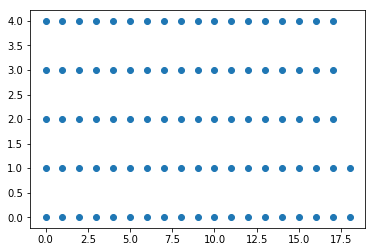

In [11]:
plt.scatter(xes, yes)

# SVG testing

In [5]:
districts = sim.districts[-1]

In [6]:
[d.zoned_as[-1] for d in districts]

[1, 1, 1, 1, 1, 2, 2, 4, 4, 16]

In [ ]:
#d.append(draw.Rectangle(0,0,40,50, fill = ))
# d.append(draw.Lines(-80, -45,
#                     70, -49,
#                     95, 49,
#                     -90, 40,
#                     close=False,
#             fill='#eeee00',
#             stroke='black'))

 # Set number of pixels per geometry unit
#d.setRenderSize(400,200)  # Alternative to setPixelScale
#d.saveSvg('example.svg')
#d.savePng('example.png')

# Display in iPython notebook
#d.rasterize()  # Display as PNG

In [7]:
sizes = [92, 9, 17, 73, 45, 1]

In [63]:
sim.blocks[-1][1:]

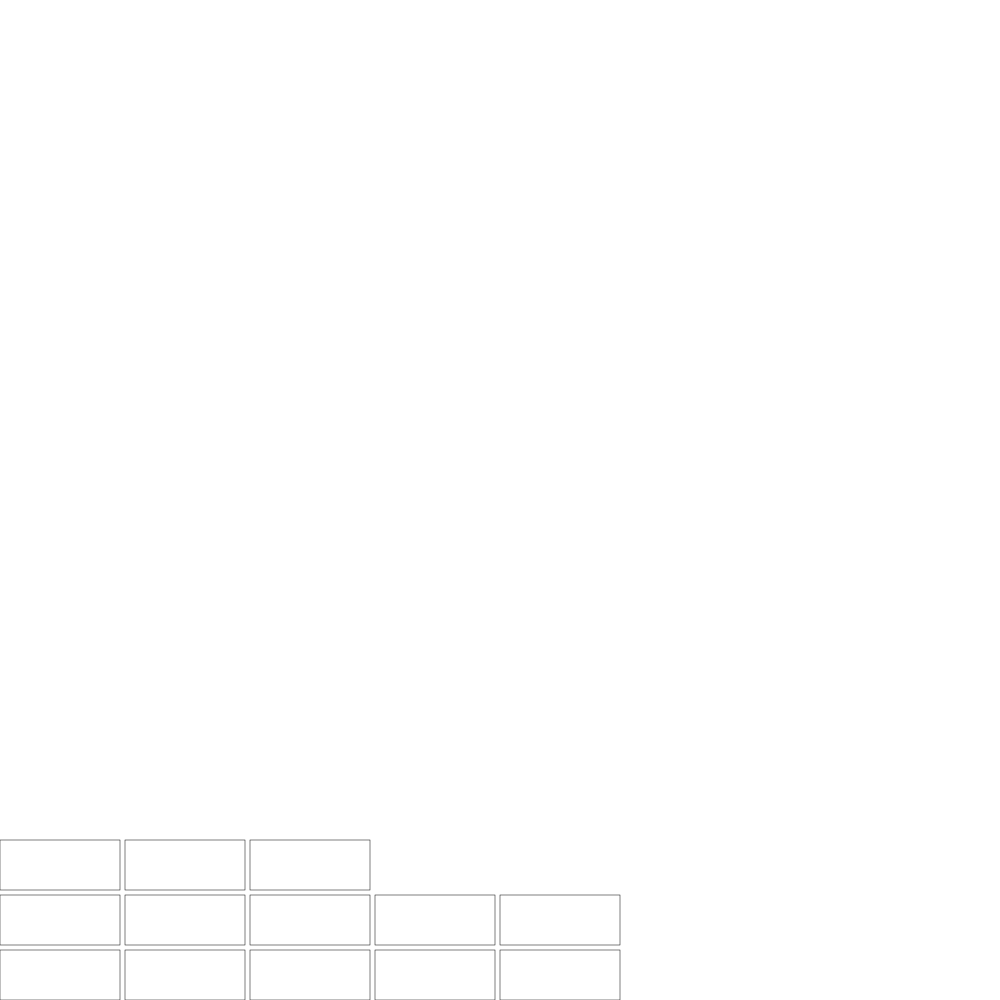

In [18]:
drawing = draw.Drawing(200, 200, origin = (0,0))

block = draw.Lines((0), (0),
                  (0), (0 + 10),
                  (0 + 24), (0 + 10),
                  (0 + 24), (0),
                  fill = 'white',
                  close = True,
                  stroke = 'black',
                  stroke_width = '0.1',
                  id = 'block')
x = 25
y = 0
block_count = 12
column = 1
column_max = 4

#Draw first block from which to copy the others
drawing.append(block)
#Start at index 1 not index 0
for b in range(block_count):
    #Reset for new row above previous
    if column > column_max:
        column = 0
        x = 0
        y += 11
    drawing.append(draw.Use('block', x, y))
    #DRAW ALL BUILDINGS HERE. Pass x and y
    x += 25
    column += 1

drawing.setPixelScale(5) 

# RESUME HERE. Working on drawing buildings within blocks.

In [76]:
residences = [r.size for r in sim.blocks[-1][0].residences[-1]]
residences

[12224.0, 37715.0, 4206.0, 38739.0, 3784.0, 3219.0, 568.0, 1370.0]

In [9]:
def rectangular_size(size):
    '''To draw a rectangle representing the area of a residence,
    the y is always 5. X is the size divided by 2125. 425 for the 425
    points in a 10 x 24 grid, 5 for the number of columns of depth 5.'''
    
    rect_size = size // 2125
    if rect_size == 0:
        rect_size = 1
    return rect_size

def set_top_bot_rows(residences):
    '''
    #Two rows: top of block and bottom of block. Sort buildings big to 
    small then divide into two lists so that roughly
    #half the buildings are on each half of the block.
    '''
    residences_sorted = sorted([r for r in residences], key = lambda r: r, reverse = True)
    rect_sizes = [rectangular_size(r) for r in residences_sorted]
    top_row = []
    TOP_SPACE = 24
    bot_row = []
    #Fill top row with sizes that fit
    for i, r in enumerate(rect_sizes):
        if TOP_SPACE >= rect_sizes[i]:
            top_row.append(rect_sizes[i])
            TOP_SPACE -= rect_sizes[i]
            rect_sizes.pop(i)
    #Put the rest in the bottom row
    bot_row.extend(rect_sizes)
    return top_row, bot_row

In [101]:
top_row, bot_row = set_top_bot_rows(residences)

# Testing reveals that some residences are exceeding the limit because those under 1 are being rounded up to 1. 

# Figure out a way to draw them as individual points out of 5?

In [ ]:
#Code for placement on grid has to be reversed somehow? Or not if they're all 5 deep.
#X is 0 for bottom row, X is + 5 for top row.
#Absolute x shoudl feed in from larger loop that is drawing the blocks.

In [6]:
len(sim.blocks[-1])

9804

In [13]:
results = [set_top_bot_rows([r.size for r in b.residences[-1]]) for b in sim.blocks[-1]]

In [14]:
tops = [r[0] for r in results]

In [16]:
bottoms = [r[1] for r in results]

In [26]:
top_sums = [sum(t) for t in tops]
bot_sums = [sum(b) for b in bottoms]

In [27]:
sums = list(zip(top_sums, bot_sums))

In [47]:
import pandas as pd
df = pd.DataFrame(data = np.array([results, tops, top_sums, bottoms, bot_sums, totals]).T, 
             columns = ['results', 'tops', 'top_sums', 'bottoms', 'bot_sums', 'totals'])

In [48]:
df.head()

,results,tops,top_sums,bottoms,bot_sums,totals
0,"([16.0, 5.0, 2.0, 1], [14.0, 5.0, 1.0, 1, 1])","[16.0, 5.0, 2.0, 1]",24,"[14.0, 5.0, 1.0, 1, 1]",22,46
1,"([21.0, 3.0], [20.0, 1, 1, 1, 1])","[21.0, 3.0]",24,"[20.0, 1, 1, 1, 1]",24,48
2,"([21.0, 3.0], [12.0, 5.0, 2.0, 1.0, 1])","[21.0, 3.0]",24,"[12.0, 5.0, 2.0, 1.0, 1]",21,45
3,"([16.0, 8.0], [14.0, 3.0, 3.0, 1.0, 1, 1, 1])","[16.0, 8.0]",24,"[14.0, 3.0, 3.0, 1.0, 1, 1, 1]",24,48
4,"([23.0, 1.0], [13.0, 5.0, 2.0, 1, 1])","[23.0, 1.0]",24,"[13.0, 5.0, 2.0, 1, 1]",22,46


In [49]:
df[df['totals'] > 48]

,results,tops,top_sums,bottoms,bot_sums,totals
36,"([17.0, 6.0, 1.0], [14.0, 4.0, 3.0, 1, 1, 1, 1])","[17.0, 6.0, 1.0]",24,"[14.0, 4.0, 3.0, 1, 1, 1, 1]",25,49
44,"([18.0, 4.0, 1, 1], [15.0, 8.0, 1, 1])","[18.0, 4.0, 1, 1]",24,"[15.0, 8.0, 1, 1]",25,49
82,"([22.0, 1, 1], [16.0, 7.0, 1, 1])","[22.0, 1, 1]",24,"[16.0, 7.0, 1, 1]",25,49
85,"([23.0, 1], [10.0, 8.0, 3.0, 1, 1, 1, 1])","[23.0, 1]",24,"[10.0, 8.0, 3.0, 1, 1, 1, 1]",25,49
90,"([21.0, 1, 1], [14.0, 11.0, 1])","[21.0, 1, 1]",23,"[14.0, 11.0, 1]",26,49
116,"([19.0, 5.0], [15.0, 4.0, 1.0, 1, 1, 1, 1, 1])","[19.0, 5.0]",24,"[15.0, 4.0, 1.0, 1, 1, 1, 1, 1]",25,49
119,"([23.0, 1], [21.0, 2.0, 1, 1, 1])","[23.0, 1]",24,"[21.0, 2.0, 1, 1, 1]",26,50
120,"([21.0, 1, 1], [18.0, 6.0, 1, 1])","[21.0, 1, 1]",23,"[18.0, 6.0, 1, 1]",26,49
136,"([16.0, 7.0, 1], [9.0, 5.0, 4.0, 4.0, 1, 1, 1])","[16.0, 7.0, 1]",24,"[9.0, 5.0, 4.0, 4.0, 1, 1, 1]",25,49
223,"([23.0, 1.0], [20.0, 3.0, 1, 1])","[23.0, 1.0]",24,"[20.0, 3.0, 1, 1]",25,49


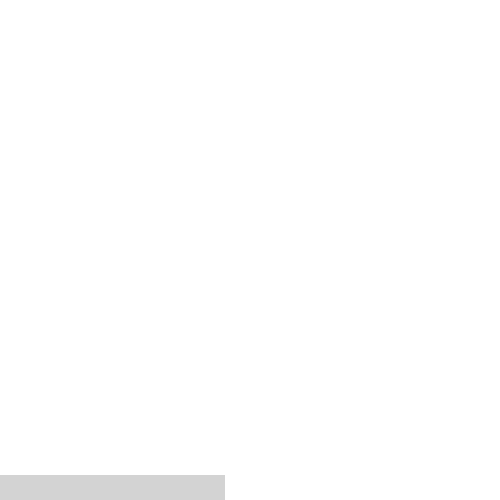

In [24]:
#rectangular_sizes = [s - (s%5) for s in sizes]

rectangular_sizes = [90, 5, 15, 70, 45, 0]

widths = [r / 5 for r in rectangular_sizes]

x_start = [0]
x_start.extend([sum(widths[:i]) for i in range(1, len(widths))])

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray', 'brown', 'black']
d = draw.Drawing(100, 100, origin = (0,0))

for x, w in zip (x_start, widths):
    d.append(draw.Rectangle(x,0,w,5, fill = 'lightgray'))
d.setPixelScale(5) 

# History Object
Make a history object?
Returns pandas series or dataframes?
hist.pop_growth(by = district)
hist.pop_density(by = district, for = 9
hist.homelessness()
hist.property_values(by = lot)
hist.avg_incomes()
hist.construction()




In [13]:
class History(object):
    def __init__(self, simulation):
        '''
        #More info on 'negative indices':
        #Households have 'has' lists of different lengths depending when they entered the sim.
        #Negative index allows loop to get the relevant value from a has list for each year.
        #.e.g. Year -11, year 0 out of 10, gets the -11th, or the first, value from a has list.
        #Year -1, year 10 out of 10, gets the -1th, or last, value from a has list. &c.
        '''
        self.sim = simulation
        
        #BY YEAR:
        l_range = np.flip(np.negative(np.arange(len(sim.blocks))) - 1)
        #Available land area
        l_avail = [sum([(b.size - sum([r.size for r in b.residences[i]])) \
                     for b in sim.blocks[i]]) for i in l_range]
        
        #Number of residences
        r_count = [len(r_list) for r_list in sim.residences]
        #Average residence size
        r_size_mean = [(sum([r.size for r in r_list]) / len(r_list)) for r_list in sim.residences]
        
        
        #Number of units
        u_count = [len(u_list) for u_list in sim.units]
        #Average unit size
        u_size_mean = [(sum([u.size for u in u_list]) / len(u_list)) for u_list in sim.units]
        #Negative indices to call on lists of varying lengths
        u_range = np.flip(np.negative(np.arange(len(sim.units))) - 1)
        #u_range does not go into dataframe
        #Average unit value
        u_value_mean = [(sum([u.value[i] for u in sim.units[i]]) / len(sim.units[i])) for i in u_range]
        
        h_count = [len(h_list) for h_list in sim.households]
        #hh_range is negative indices by which to call items from has list in each household.
        
        hh_range = np.flip(np.negative(np.arange(len(sim.households))) - 1)
        #hh_range is not included in the dataframe
        #Only households who were housed at the end of each year
        h_housed = [sum([1 for h in sim.households[i] if h.housed[i]]) for i in hh_range]
        #Only households who were unhoused at the end of each year
        h_unhoused = [sum([1 for h in sim.households[i] if not h.housed[i]]) for i in hh_range]
        #Average income of household by year
        h_has_mean = [sum([h.has[i] for h in sim.households[i]])\
                             / len(sim.households[i]) for i in hh_range]
        #Average time household spent living in sim by year
        #(i.e. average 'age' of household by year)
        h_age_mean = [sum([len(h.has[:i]) for h in sim.households[i]]\
                                ) / len(sim.households[i]) for i in hh_range]
        
        data = np.array([l_avail,
                         r_count, r_size_mean,
                         u_count, u_size_mean, u_value_mean,
                         h_count, h_housed, h_unhoused, h_has_mean, h_age_mean
                        ]).T
        columns = ['empty_land',
                    'r_count', 'r_size_mean',
                   'u_count', 'u_size_mean', 'u_value_mean', 
                   'h_count', 'h_housed', 'h_unhoused', 'h_income_mean', 'h_age_mean']
        
        
        self.all_by_year = pd.DataFrame(data = data, columns = columns).rename_axis('Year')

In [14]:
%%time
hist = History(sim)


CPU times: user 15.2 s, sys: 253 ms, total: 15.4 s
Wall time: 15.5 s


In [8]:
hist.all_by_year


,empty_land,num_residences,r_size_mean,num_units,u_size_mean,u_value_mean,num_households,h_housed,h_unhoused,h_income_mean,h_age_mean
Year,,,,,,,,,,,
0,490277331.0,200278.0,2545.071481,940532.0,530.083530,5300.835296,100000.0,83934.0,16066.0,1496.941822,0.000000
1,236171293.0,396414.0,1926.843815,1695619.0,439.814417,4398.144168,110000.0,92309.0,17691.0,1497.041025,0.909091
2,109778242.0,572733.0,1554.338435,2218225.0,390.914008,3909.140083,120000.0,100655.0,19345.0,1496.605339,1.750000
3,49617384.0,707486.0,1343.322374,2526725.0,365.597872,3655.978723,130000.0,109044.0,20956.0,1496.343235,2.538462
4,23082398.0,791562.0,1234.163286,2683978.0,353.280392,3532.803920,140000.0,117486.0,22514.0,1496.611621,3.285714
5,12604588.0,833546.0,1184.571180,2751275.0,348.078890,3480.788904,150000.0,125878.0,24122.0,1497.006561,4.000000
6,9078864.0,850357.0,1165.299154,2775344.0,346.190379,3461.903785,160000.0,134250.0,25750.0,1496.430751,4.687500
7,8079243.0,855656.0,1159.250813,2782284.0,345.644589,3456.445891,170000.0,142643.0,27357.0,1496.593091,5.352941
8,7839669.0,857060.0,1157.631307,2784031.0,345.502725,3455.027252,180000.0,151011.0,28989.0,1496.553050,6.000000


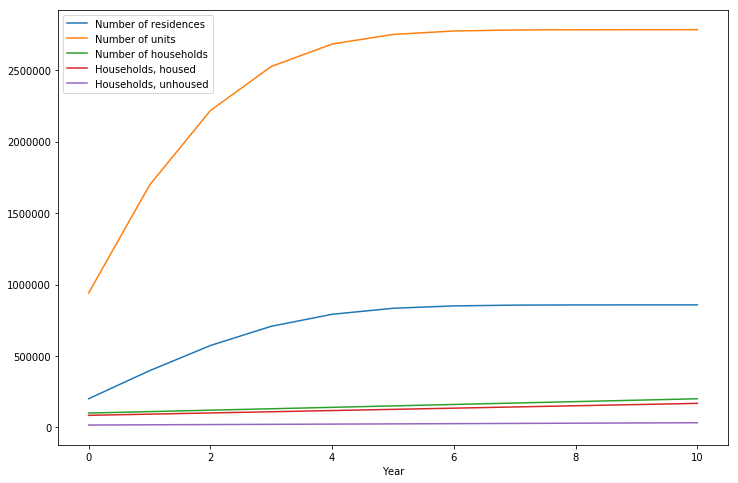

In [9]:
#Look at numbers of buildings and people by year
fig = plt.figure(figsize = (12, 8))
#plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
plt.plot(hist.all_by_year['r_count'], label = 'Number of residences')
plt.plot(hist.all_by_year['y_count'], label = 'Number of units')
plt.plot(hist.all_by_year['h_count'], label = 'Number of households')
plt.plot(hist.all_by_year['h_housed'], label = 'Households, housed')
plt.plot(hist.all_by_year['h_unhoused'], label = 'Households, unhoused')
plt.xlabel('Year')
plt.legend()
plt.show()


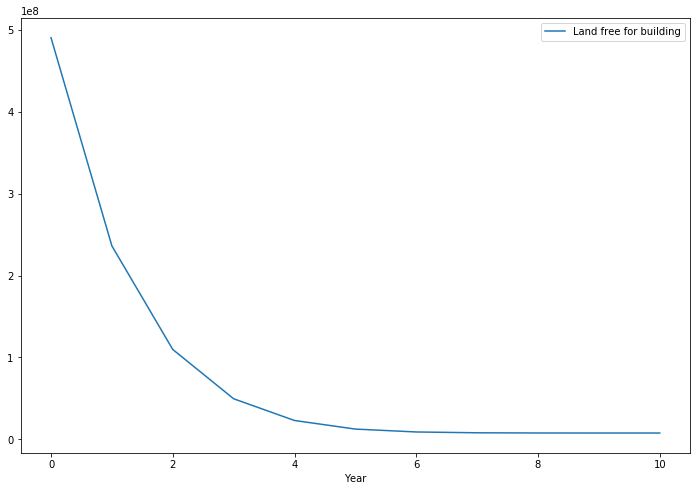

In [10]:
#Look at numbers of buildings and people by year
fig = plt.figure(figsize = (12, 8))
plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
#plt.plot(hist.all_by_year['r_count'], label = 'Number of residences')

plt.xlabel('Year')
plt.legend()
plt.show()

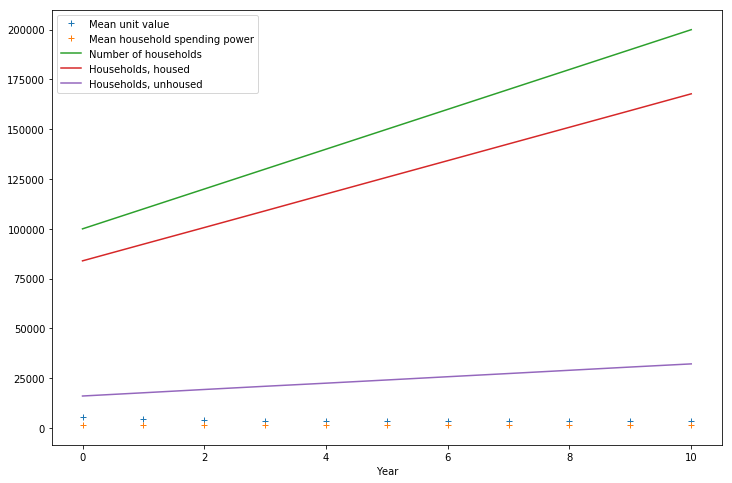

In [11]:
#Look at numbers of buildings and people by year
fig = plt.figure(figsize = (12, 8))
#plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
plt.plot(hist.all_by_year['u_value_mean'], '+', label = 'Mean unit value')
plt.plot(hist.all_by_year['h_income_mean'], '+', label = 'Mean household spending power')
plt.plot(hist.all_by_year['h_count'], label = 'Number of households')
plt.plot(hist.all_by_year['h_housed'], label = 'Households, housed')
plt.plot(hist.all_by_year['h_unhoused'], label = 'Households, unhoused')

plt.xlabel('Year')
plt.legend()
plt.show()



# VARIOUS CHECKS FOR OBJECTS IN SIM

In [ ]:
#Zoning of each district
#[d.zoned_as[-1] for d in sim.districts[-1]]

#How many blocks per district
#[len(d.blocks[-1]) for d in sim.districts[-1]]

#CHECK FOR UNIT COUNTS IN DIFFERENT SIZED RESIDENCES
#how to write nested comp: smallest for biggest in biggest for second biggest in second biggest for third biggest in third biggest
#r_sizes = [r.size for d in sim.districts[-1] for b in d.blocks[-1] for r in b.residences[-1]]
#r_unit_count = [len(r.units[-1]) for d in sim.districts[-1] for b in d.blocks[-1] for r in b.residences[-1]]
#for size, unit_count in zip(r_sizes, r_unit_count):
#    print(size, unit_count)

In [ ]:
#For history object
#Test for lengths of these lists. They should all be equal length.
# print(len(residences_count))
# print(len(residence_size_avg))
# print(len(units_count))
# print(len(unit_size_avg))
# print(len(unit_value_avg))
# print(len(household_count))
# print(len(households_housed))
# print(len(households_unhoused))
# print(len(household_age_avg))
# print(len(household_has_avg))

In [ ]:
#This is the available area on one lot
#(sim.lots[0][0].size - sum([r.size for r in sim.lots[0][0].residences[0]]))

#Available area for all lots in one year
#[(l.size - sum([r.size for r in l.residences[0]])) \
#     for l in sim.lots[0]]

#Total area for one year vs avail area for one year
#total = sum([l.size  for l in sim.lots[0]])
#avail = sum([(l.size - sum([r.size for r in l.residences[0]])) \
     #for l in sim.lots[0]])

In [ ]:
#Check sizes of all lots
#sum([lot.size for lot in sim.lots[-1]])

In [ ]:
#Check size of each residence
#[residence.size for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check size of each unit
#unit_sizes = [unit.value for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]]

In [ ]:
len(unit_sizes)

In [ ]:
set(unit_sizes)

In [ ]:
plt.hist(unit_sizes, bins = 50)

In [ ]:
#Check area of each residence that isn't carved into units
#[(residence.size - sum(unit.size for unit in residence.units[-1])) for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check unbuilt land of each lot
#avail_area = [lot.size - sum([residence.size for residence in lot.residences[-1]]) for lot in sim.lots[-1]]
#Avail area on each lot should be less than min_size for building a new residence
#avail_area

In [ ]:
#Check how many residences on each lot
#[len(lot.residences[-1]) for lot in sim.lots[-1]]

In [ ]:
#Check how many units in each residence
#[len(residence.units[-1]) for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check a single lot
#vars(sim.lots[-1][0])

In [ ]:
#Check a single residence on a lot
#vars(sim.lots[-1][0].residences[-1][0])

In [ ]:
#Check a single unit in a residence
#vars(sim.lots[-1][0].residences[-1][0].units[-1][0])

In [ ]:
#THIS IS GREAT CODE DON'T DELETE
#Check all unit values
#How to quadruple nest a list comprehension:
#smallest for biggest in biggest for second biggest in second biggest for third biggest in third biggest
unit_values = [unit.value[-1] for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]]
#unit_values
#plt.hist(unit_values)

In [ ]:
#Get total number of units in all residences on all lots
len([unit.value[-1] for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]])

In [ ]:
#Check incomes for all households
#incomes = [household.has[-1] for household in sim.households[-1]]
#plt.hist(incomes)

In [ ]:
#Check incomes for currently housed households
#incomes_currently_housed = [household.has[-1] for household in sim.households[-1] if household.housed[-1]]
#plt.hist(incomes_currently_housed)

In [ ]:
#Check housing history for all households
#housing_history = [household.housed for household in sim.households[-1]]
#housing_history

In [ ]:
uvals = [u.value[-1] for u in sim.units[-1] if not u.occ[-1]]

In [ ]:
hhases = [h.has[-1] for h in sim.households[-1] if not h.housed[-1]]



In [ ]:
np.array(uvals).min()


In [ ]:
np.array(hhases).max()


In [ ]:
# #Test for instantiation of lots, residences built by developers, units per residence
# for lot in sim.lots[-1]:
#     print('Lot size:', lot.size)
#     print('Number of buildings on lot:', len(lot.residences[-1]))
#     for residence in lot.residences[-1]:
#         print('Building size:', residence.size)
#         print('Building zoned as:', residence.zoned_as)
#         print('Units in building:', len(residence.units[-1]))
#         print('Sqft per unit:', residence.size / len(residence.units[-1]))
#         for unit in residence.units[-1]:
#             print('Unit size:', unit.size)
#             print('Unit initial value:', unit.value[0])
#             print('Unit current value:', unit.value[-1])
#             print('Household size:', unit.occ[-1].size)
#             print('Household spending power:', unit.occ[-1].size)
#     print('\n')

In [ ]:
#CITY SETTINGS
#Size of land area in sqft (for now)
land = 1000000 #one trillion sqft in SF
lot_count = 1000 #800,000 in SF
lot_size_avg = 2000
lot_size_std = 500

#Starting population
pop_start = 1000
has_avg = 2000
has_std = 500

#Time and money
inflation = 0.02
years = 10

#Probability distribution of house sizes
#house_size_dist = np.random.normal(scale = house_size_std, loc = avg_house_size, size = households)


sim = Simulation(total_time_steps = years, 
                 land = land, 
                 lot_count = lot_count, 
                 lot_size_avg = lot_size_avg, 
                 lot_size_std = lot_size_std,
                 pop_start = pop_start, 
                 has_avg = has_avg, 
                 has_std = has_std, 
                 inflation = inflation,
                 )

# Viz: Assigning lots at start of sim (throws an error when top of grid is reached)

In [ ]:
#VIZ
def draw_land_grid(land):
    '''Writes a dict of y values, each with a dict of x values.
    Works as a grid of xes and yes.'''
    root = int(np.round(np.sqrt(land), 0) + 3)
    x_range = root
    y_range = root
    #Each point in the dict will get switched True when a house is drawn on it
    grid = {y: {x: False for x in np.arange(x_range)} for y in np.arange(y_range)}
    return grid

def assign_loc(lot, x, y, frontage):
    '''
    Assign a location to a lot.
    '''
    xes = np.arange(x, x + frontage)
    yes = np.arange(y, y + frontage)
    loc = [(x, y) for y in yes for x in xes]
    lot.loc = loc
    
def fill_coords(grid, loc):
    '''
    Fill the coords in the grid dict after assignment of previous lot.
    '''
    for coord in loc:
        #Reset the point to True in the dict of grid
        grid[coord[1]][coord[0]] = True

def avail(grid, x_, y_, frontage):
    #X adjusted to the left for padding
    x = x_ - 1
    #Y adjusted to the left for padding
    y = y_ - 1
    x_range = np.arange((x), (x + frontage + 2))
    y_range = np.arange((y), (y + frontage + 2))
    #List of bools returned from each point checked
    bottom = [grid[y][x_i] for x_i in x_range[:-1]]
    top = [grid[y + frontage][x_i] for x_i in x_range[1:]]
    left = [grid[y_i][x] for y_i in y_range[1:]]
    right = [grid[y_i][x + frontage] for y_i in y_range[:-1]]
    
    #Value of all bools
    points = sum(bottom) + sum(top) + sum(left) + sum(right)
    
    #If even one point in the proposed lot is taken (points != 0)
    if points:
        return False
    #If not a single point in the proposed lot is taken (points == 0)
    else:
        #print(x, y, 'is avail!')
        return True

#(Each row is a tuple of (x, bool))
def find_loc(grid, lot, next_x, next_y):
    '''
    #Traverse each row in the land grid via grid dict
    '''
    #Padding -1 right side
    x_range = len(grid[0]) - 1
    #Padding -1 top
    y_range = len(grid) - 1
    
    #One side of the square lot
    frontage = int(np.round(np.sqrt(lot.size), 0))
    
     #Traverse the y rows in the grid dict
    for y in np.arange(next_y, y_range):
        #If row isn't too full for this lot
        if x_range - sum([v for k, v in grid[y].items()]) > frontage:
            #print('Looking in row', y)
            #Traverse the row of x values
            for x in np.arange(next_x, x_range):
                #print('Looking in x', x)
                #If the right side of the lot is at the right edge of the grid, 
                #and at or below the top, continue
                if ((x + frontage) <= (x_range - 1)) and ((y + frontage) <= (y_range - 1)):
                    #If all frontage points in the proposed lot return False
                    if avail(grid, x, y, frontage):
                        #print('Assigning lot at', x, y)
                        #House gets assigned these coords
                        assign_loc(lot, x, y, frontage)
                        #Coords get changed to True in the grid dict
                        fill_coords(grid, lot.loc)
                        #Break the loop
                        #print('Found lot for ', lot.size)
                        #Return next x and next y to start on
                        #print((x + frontage), y)
                        return (x + frontage), y
        #If spot isn't found, reset x to 0 before moving up to next y
        #(Start at 1, not 0, for padding on left side)
        next_x = 1


In [ ]:
#Draw grid for sim
grid = draw_land_grid(land)

counter = 0
#Padding +1
next_x = 1
#Padding +1
next_y = 1

for _ in tqdm(range(len(sim.housing_stock))):
    #Draw a lot on the grid
    next_x, next_y = find_loc(grid, sim.housing_stock[_], next_x, next_y)
    #counter += 1
    #print(counter, 'out of', len(sim.housing_stock))

In [ ]:
#What does the grid look like?
grid[0]

In [ ]:
sim.housing_stock[10].sold

In [ ]:
sim.run()

# Visualizing lots (some overlap)

In [ ]:
#Draw viz of all lots
fig = plt.figure(figsize = (14,14))
for lot in sim.housing_stock:
    if lot.sold:
        color = 'blue'
    else:
        color = np.random.choice(['dimgray', 'darkgray', 'silver', 'slategray', 'powderblue', 'whitesmoke'])
    x = [point[0] for point in lot.loc]
    y = [point[1] for point in lot.loc]
    #ADD IF STATEMENT FOR SALE OF LOT
    plt.scatter(x, y, label = lot.size, marker = 's', color = color)
plt.show()

In [ ]:
#Draw viz of all lots
fig = plt.figure(figsize = (14,14))
for lot in sim.housing_stock:
    if lot.sold:
        color = 'blue'
    else:
        color = np.random.choice(['dimgray', 'darkgray', 'silver', 'slategray', 'powderblue', 'whitesmoke'])
    x = [point[0] for point in lot.loc]
    y = [point[1] for point in lot.loc]
    #ADD IF STATEMENT FOR SALE OF LOT
    plt.scatter(x, y, label = lot.size, marker = 's', color = color)
plt.show()